In [46]:
import fsspec
import xarray as xr
import copy as copy
import cmocean
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


zarr_data_path = 'gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr'
nc_grid_path = 'gs://leap-persistent/sd5313/OM4-5daily/ocean_static_no_mask_table.nc'

ds_raw = xr.open_dataset(zarr_data_path, engine='zarr', chunks={}).isel(time=0)

with fsspec.open(nc_grid_path) as f:
    ds_grid = xr.open_dataset(f).load().drop_vars('time')
ds_grid = ds_grid.set_coords(ds_grid.data_vars)

ds = xr.merge([ds_raw, ds_grid])
ds

<xarray.Dataset> Size: 666MB
Dimensions:       (lev: 19, nv: 2, xh: 1440, xq: 1441, yh: 1080, yq: 1081)
Coordinates: (12/34)
  * lev           (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
  * nv            (nv) float64 16B 1.0 2.0
  * xh            (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * xq            (xq) float64 12kB -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yh            (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * yq            (yq) float64 9kB -80.43 -80.35 -80.27 ... 89.78 89.89 90.0
    ...            ...
    dxCv          (yq, xh) float32 6MB nan nan nan ... 1.21e+04 1.215e+04
    dyCv          (yq, xh) float32 6MB nan nan nan nan ... 246.8 148.7 49.76
    areacello_cu  (yh, xq) float32 6MB nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    areacello_cv  (yq, xh) float32 6MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    areacello_bu  (yq, xq) float32 6MB nan nan nan ... 1.203e+06 4.55e+05
    basin         (yh, xh) int32 6MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    hfds          (yh, xh) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    so            (lev, yh, xh) float32 118MB dask.array<chunksize=(19, 1080, 1440), meta=np.ndarray>
    tauuo         (yh, xq) float32 6MB dask.array<chunksize=(1080, 1441), meta=np.ndarray>
    tauvo         (yq, xh) float32 6MB dask.array<chunksize=(1081, 1440), meta=np.ndarray>
    thetao        (lev, yh, xh) float32 118MB dask.array<chunksize=(19, 1080, 1440), meta=np.ndarray>
    time_bnds     (nv) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    uo            (lev, yh, xq) float32 118MB dask.array<chunksize=(19, 1080, 1441), meta=np.ndarray>
    vo            (lev, yq, xh) float32 118MB dask.array<chunksize=(19, 1081, 1440), meta=np.ndarray>
    zos           (yh, xh) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_5daily_cycle1

In [47]:
#Library of Transects w/ plot options

Transect = {}

Transect['Mediterranean Outflow']={}
Transect['Mediterranean Outflow']['Type']='Zonal'
Transect['Mediterranean Outflow']['LonLim'] = [-75,15]
Transect['Mediterranean Outflow']['Lat'] = 36
Transect['Mediterranean Outflow']['SaltLevels'] = np.linspace(35,36.6,21)
Transect['Mediterranean Outflow']['TempLevels'] = np.linspace(5,15,11)
Transect['Mediterranean Outflow']['ZMax'] = 5500

Transect['Equatorial Pacific']={}
Transect['Equatorial Pacific']['Type']='Zonal'
Transect['Equatorial Pacific']['LonLim'] = [-220,-80]
Transect['Equatorial Pacific']['Lat'] = 0
Transect['Equatorial Pacific']['SaltLevels'] = np.linspace(34.5,35.5,21)
Transect['Equatorial Pacific']['TempLevels'] = np.linspace(2,30,26)
Transect['Equatorial Pacific']['ZMax'] = 5500

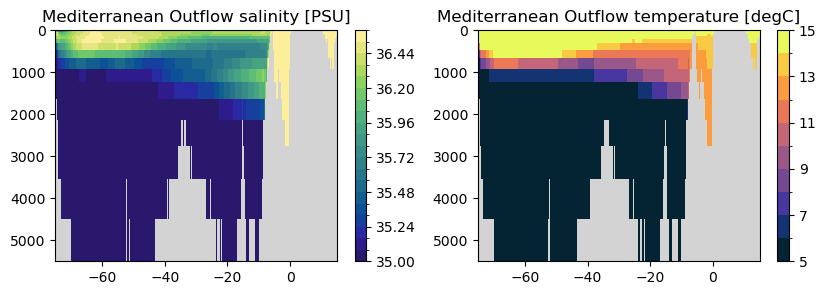

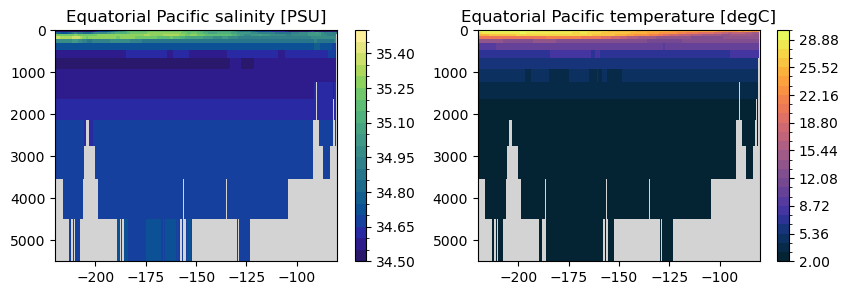

In [53]:

for Region in Transect:
    # If printing the salinity transect
    
    varMOM_S='so'
    varMOM_T='thetao'
    if (Transect[Region]['Type']=='Zonal'):
        Lat = Transect[Region]['Lat']
        LonLim = Transect[Region]['LonLim']
        
        Zmod = ds.lev
        ii = np.argmin(abs(ds.geolat.values[:,0]-Lat))
        XXmod = ds.geolon.values[ii,:]
        YYmod = ds.geolat.values[ii,0]
        f,a = plt.subplots(1,2,figsize=(10,3))

        # Salinity
        Cmod = ds[varMOM_S].isel(yh=ii)
        levels = Transect[Region]['SaltLevels']
        cmap = copy.copy(cmocean.cm.haline)
        cmap.set_bad('lightgray')
        ax=a.ravel()[0]
        c=ax.pcolormesh(XXmod,Zmod,Cmod,
                            norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),
                            cmap=cmap)
        ax.set(ylim=[Transect[Region]['ZMax'],0],
               xlim=Transect[Region]['LonLim'])
        ax.set(title=Region+' salinity [PSU]')
        plt.colorbar(c,ax=ax)

        # Temperature
        Cmod = ds[varMOM_T].isel(yh=ii)
        levels = Transect[Region]['TempLevels']
        cmap = copy.copy(cmocean.cm.thermal)
        cmap.set_bad('lightgray')
        ax=a.ravel()[1]
        c=ax.pcolormesh(XXmod,Zmod,Cmod,
                            norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),
                            cmap=cmap)
        ax.set(ylim=[Transect[Region]['ZMax'],0],
               xlim=Transect[Region]['LonLim'])
        ax.set(title=Region+' temperature [degC]')
        plt.colorbar(c,ax=ax)
    else:
        print('Not set up for non Zonal transect yet')